# Accuracy=99.75% using 25 Million Training Images!!
It's amazing that convolutional neural networks can classify handwritten digits so accurately. In this kernel, we witness an ensemble of 15 CNNs classify Kaggle's MNIST digits after training on Kaggle's 42,000 images in "train.csv" plus 25 million more images created by rotating, scaling, and shifting Kaggle's images. Learning from 25,042,000 images, this ensemble of CNNs achieves 99.75% classification accuracy. This kernel uses ideas from the best published models found on the internet. Advanced techniques include data augmentation, nonlinear convolution layers, learnable pooling layers, ReLU activation, ensembling, bagging, decaying learning rates, dropout, batch normalization, and adam optimization. 

In [21]:
# LOAD LIBRARIES
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from tensorflow.python.client import device_lib
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


# Load Kaggle's 42,000 training images

In [22]:
# LOAD THE DATA
train = pd.read_csv("./input_digits/train.csv")
test = pd.read_csv("./input_digits/test.csv")

In [23]:
# PREPARE DATA FOR NEURAL NETWORK
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1)
X_train = X_train / 255.0
X_test = test / 255.0
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)
Y_train = to_categorical(Y_train, num_classes = 10)

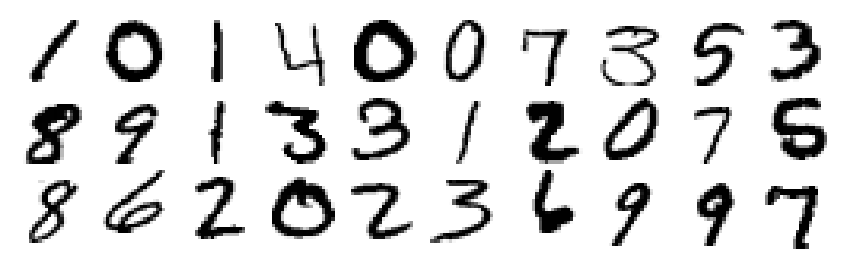

In [24]:
import matplotlib.pyplot as plt
# PREVIEW IMAGES
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    plt.imshow(X_train[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

# Generate 25 million more images!!
by randomly rotating, scaling, and shifting Kaggle's 42,000 images.

In [25]:
# CREATE MORE IMAGES VIA DATA AUGMENTATION
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

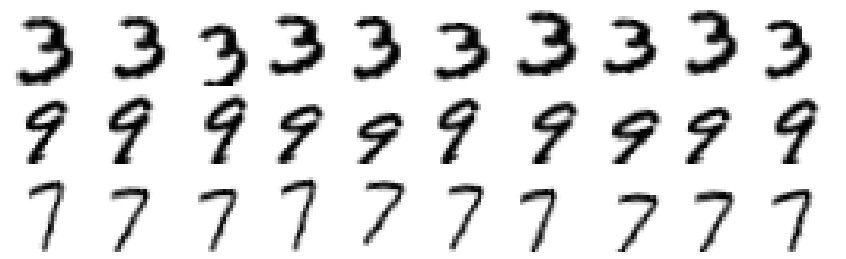

In [26]:
# PREVIEW AUGMENTED IMAGES
X_train3 = X_train[9,].reshape((1,28,28,1))
Y_train3 = Y_train[9,].reshape((1,10))
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    X_train2, Y_train2 = datagen.flow(X_train3,Y_train3).next()
    plt.imshow(X_train2[0].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
    if i==9: X_train3 = X_train[11,].reshape((1,28,28,1))
    if i==19: X_train3 = X_train[18,].reshape((1,28,28,1))
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

# Build 15 Convolutional Neural Networks!

In [27]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 15
model = [0] *nets
for j in range(nets):
    model[j] = Sequential()

    model[j].add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(128, kernel_size = 4, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Flatten())
    model[j].add(Dropout(0.4))
    model[j].add(Dense(10, activation='softmax'))

    # COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Architectural highlights
![](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/2020/LeNet5.png)

The CNNs in this kernel follow [LeNet5's][1] design (pictured above) with the following improvements:  
* Two stacked 3x3 filters replace the single 5x5 filters. These become nonlinear 5x5 convolutions
* A convolution with stride 2 replaces pooling layers. These become learnable pooling layers.
* ReLU activation replaces sigmoid.
* Batch normalization is added
* Dropout is added
* More feature maps (channels) are added
* An ensemble of 15 CNNs with bagging is used  
  
Experiments [(here)][2] show that each of these changes improve classification accuracy.

[1]:http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf
[2]:https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist

# Train 15 CNNs

In [28]:
# DECREASE LEARNING RATE EACH EPOCH
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
# TRAIN NETWORKS
history = [0] * nets
epochs = 45
for j in range(nets):
    print(j)
    X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size = 0.1)
    history[j] = model[j].fit(datagen.flow(X_train2,Y_train2, batch_size=64),
        epochs = epochs, steps_per_epoch = X_train2.shape[0]//64,  
        validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0)
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        j+1,epochs,max(history[j].history['acc']),max(history[j].history['val_acc']) ))

0


KeyboardInterrupt: 

# Ensemble 15 CNN predictions and submit

In [ ]:
# ENSEMBLE PREDICTIONS AND SUBMIT
results = np.zeros( (X_test.shape[0],10) ) 
for j in range(nets):
    results = results + model[j].predict(X_test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("MNIST-CNN-ENSEMBLE.csv",index=False)

In [ ]:
# PREVIEW PREDICTIONS
plt.figure(figsize=(15,6))
for i in range(40):  
    plt.subplot(4, 10, i+1)
    plt.imshow(X_test[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.title("predict=%d" % results[i],y=0.9)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()

# Kaggle Result
![result](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/2020/MNIST-result-DA4a.png)

Wow, its amazing that convolution neural networks can classify handwritten digits so accurately; 99.75% is as good as a human can classify!! This ensemble of 15 CNNs was trained with Kaggle's "train.csv" 42,000 images plus 25 million more images created by rotating, scaling, and shifting Kaggle's "train.csv" images.

# How much more accuracy is possible?
Not much. Here are the best published MNIST classifiers found on the internet:
* 99.79% [Regularization of Neural Networks using DropConnect, 2013][1]
* 99.77% [Multi-column Deep Neural Networks for Image Classification, 2012][2]
* 99.77% [APAC: Augmented PAttern Classification with Neural Networks, 2015][3]
* 99.76% [Batch-normalized Maxout Network in Network, 2015][4]
* **99.75% [This Kaggle published kernel, 2018][12]**
* 99.73% [Convolutional Neural Network Committees, 2011][13]
* 99.71% [Generalized Pooling Functions in Convolutional Neural Networks, 2016][5]
* More examples: [here][7], [here][8], and [here][9]  
  
On Kaggle's website, there are no published kernels more accurate than 99.70% besides the one you're reading. The few you will find posted were trained on the full original MNIST dataset (of 70,000 images) which contains known labels for Kaggle's unknown "test.csv" images so those models aren't actually that accurate. For example, [one kernel achieves 100% accuracy][10] training on the original MNIST dataset.  
  
Below is a annotated histogram of Kaggle submission scores. Each bar has range 0.1%. There are spikes at 99.1% and 99.6% accuracy corresponding with using convolutional neural networks. Frequency count decreases as scores exceed 99.69%, hitting a low at 99.8% which is just past the highest possible accuracy. Then frequency count spikes again at accuracies of 99.9% and 100.0% corresponding to mistakenly training with the full original MNIST dataset.  
  
![hist](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/2020/KaggleMNISThist3.png)

[1]:https://cs.nyu.edu/~wanli/dropc/dropc.pdf
[2]:http://people.idsia.ch/~ciresan/data/cvpr2012.pdf
[3]:https://arxiv.org/abs/1505.03229
[4]:https://arxiv.org/abs/1511.02583
[5]:https://arxiv.org/abs/1509.08985
[7]:http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html
[8]:http://yann.lecun.com/exdb/mnist/
[9]:https://en.wikipedia.org/wiki/MNIST_database
[10]:https://www.kaggle.com/cdeotte/mnist-perfect-100-using-knn/
[12]:https://www.kaggle.com/cdeotte/35-million-images-0-99757-mnist
[13]:http://people.idsia.ch/~ciresan/data/icdar2011a.pdf
[14]:http://www.mva-org.jp/Proceedings/2015USB/papers/14-21.pdf

# How well can a human classify?
Take the following quiz. Here are 50 of the most difficult images from Kaggle's "test.csv". For each image, write down a guess as to what digit it is. Then click the link below to see the correct answers. Hint: Nothing on the bottom row is what it seems and the top 4 rows contain 9 different digits!!  Good luck!  
  
    
![quiz](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/2020/unknown.png)  
  
  
Click [here][1] for the answers. The ambiguity and/or mislabeling of certain images is why classifiers cannot achieve accuracy greater than 99.8%. Roughly speaking your overall accuracy on the entire MNIST test dataset would be equal to 100% minus 0.01% times the quantity you got wrong in this quiz.

[1]:http://playagricola.com/Kaggle/answers.png

# Credits
The code here was inspired by the following outstanding Kaggle kernels (in addition to the publications above).

* [Yassine Ghouzam][1] - [Introduction to CNN Keras - 0.997 (top 6%)][2]
* [Peter Grenholm][5] - [Welcome to deep learning (CNN 99%)][6]
* [Ding Li][3] - [Digits Recognition With CNN Keras][4]
* [Aditya Soni][7] - [MNIST with Keras for Beginners(.99457)][8]

[1]:https://www.kaggle.com/yassineghouzam
[2]:https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6
[3]:https://www.kaggle.com/dingli
[4]:https://www.kaggle.com/dingli/digits-recognition-with-cnn-keras
[5]:https://www.kaggle.com/toregil
[6]:https://www.kaggle.com/toregil/welcome-to-deep-learning-cnn-99/
[8]:https://www.kaggle.com/adityaecdrid/mnist-with-keras-for-beginners-99457/
[7]:https://www.kaggle.com/adityaecdrid

# CNN Performance
How can we evaluate the performance of a neural network? A trained neural network performs differently each time you train it since the weights are randomly initialized. Therefore, to assess a neural network's performance, we must train it many times and take an average of accuracy. The ensemble in this notebook was trained and evaluated 100 times!! (on the original MNIST dataset with 60k/10k split using the code template [here][1] on GitHub.) Below is a histogram of its accuracy.  
  
The maximum accuracy of an individual CNN was 99.81% with average accuracy 99.641% and standard deviation 0.047. The maximum accuracy of an ensemble of fifteen CNNs was 99.79% with average accuracy 99.745% and standard deviation 0.020.  
  
![hist](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/2020/histBoth5.png)

## Data augmentation hyper-parameters
To determine the best hyper-parameters for data augmentation, grid search was used. Below is the accuracy of an ensemble (of 15 CNNs) with various data augmentation settings. The columns are `rotation` and `zoom`. The rows are `w_shift` and `h_shift`. For example: row 2, column 4 is `r = 15, z = 0.15, w = 0.1, h = 0.1`. Each cell is the average of 6 trials:  
  
            0      5     10      15     20     25     30  
    0     99.70  99.70  99.70  99.70  99.69  99.65  99.62
    0.1   99.73  99.73  99.75  99.75  99.72  99.67  99.64 
    0.2                 99.72  99.72

Below is the accuracy of a single CNN with various data augmentation settings. Each cell is the average of 30 trials.  
  
            0      5     10      15     20     25     30  
    0     99.57  99.58  99.62  99.62  99.62  99.57  99.52
    0.1   99.62  99.63  99.65  99.65  99.63  99.58  99.52  
    0.2                 99.62  99.62
  
Lastly, I calculated the variance of the MNIST training images. The average center in pixels = (14.9, 15.2). The standard deviation of centers in pixels = (0.99, 1.34). That means that a setting of `w_shift = 0.07` together with `h_shift = 0.09` contains 95% of the centers. Similar analysis shows that a setting of `rotation_range = 13` together with `zoom_range = 0.13` contains 95% of the images.   
  
Based on this analysis, the settings of `rotation_range = 10, zoom_range = 0.10, w_shift = 0.1, and h_shift = 0.1` were chosen.

[1]:https://github.com/cdeotte/MNIST-CNN-99.75